## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=500, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=20,     # Number of steps each sampled episode should contain
    batchSize=10,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.01)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.01),
            GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.01),
#             GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=5.0, noiseLevel=0.01),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='Micro-2Gens-Cost-0_5k-PF2'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.01)], generators=[GeneratorSpecs(id_='G1', basePower=1.5, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=3.0, noiseLevel=0.01), GeneratorSpecs(id_='G2', basePower=1.5, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=3.0, noiseLevel=0.01)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=500, maxSteps=100, bufferSize=500, traceLength=20, batchSize=10, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), explorationNoiseSize=0.4, actionScale=0.1, modelName='Micro-2Gens-Cost-0_5k-PF2')

Train Agents

In [18]:
def rewardFn(totalCost, outputDifferential):
    scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    costComponent = 2**(-1*(scaledCost**2)*200)
    outputComponent = 2**(-1*(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent
    
#     print(f'Scaled_Cost:{scaledCost} - OutputDiff:{outputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [19]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0920 18:54:56.666834 140206688831232 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0920 18:54:56.668558 140206688831232 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0920 18:54:56.695755 140206688831232 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: Micro-2Gens-Cost-0_5k-PF2 - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/Micro-2Gens-Cost-0_5k-PF2/model
CPU times: user 1h 22s, sys: 9min 45s, total: 1h 10min 7s
Wall time: 28min 27s


In [20]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:0.03238002818374572 - OutputDiff:3.913726101259299e-07 - costComponent:0.8647210742379973 - outputComponent:0.9999999999469145 - reward:0.8647210741920931
Scaled_Cost:0.03242074683742109 - OutputDiff:3.913726101259299e-07 - costComponent:0.8644048277707099 - outputComponent:0.9999999999469145 - reward:0.8644048277248225
Scaled_Cost:0.03246818549129674 - OutputDiff:3.913726101259299e-07 - costComponent:0.8640360345196975 - outputComponent:0.9999999999469145 - reward:0.8640360344738296
Scaled_Cost:0.03252234414537266 - OutputDiff:3.913726101259299e-07 - costComponent:0.863614532850593 - outputComponent:0.9999999999469145 - reward:0.8636145328047475
Scaled_Cost:0.03258322279964885 - OutputDiff:3.913726101259299e-07 - costComponent:0.8631401387729213 - outputComponent:0.9999999999469145 - reward:0.863140138727101
Scaled_Cost:0.03265082157268975 - OutputDiff:3.9632669379841005e-07 - costComponent:0.8626126452295058 - outputComponent:0.999999999945562 - reward:0.8626126451825469


Scaled_Cost:0.03303295167057869 - OutputDiff:0.0015321877566719438 - costComponent:0.8596163454859325 - outputComponent:0.9991867149702315 - reward:0.8589172323808044
Scaled_Cost:0.03303295220644237 - OutputDiff:0.0015322079445619643 - costComponent:0.8596163412671044 - outputComponent:0.99918669354735 - reward:0.8589172097499485
Scaled_Cost:0.0330329535247328 - OutputDiff:0.0015322576092488911 - costComponent:0.8596163308882693 - outputComponent:0.9991866408432329 - reward:0.8589171540742349
Scaled_Cost:0.033032954599747644 - OutputDiff:0.0015322981088791339 - costComponent:0.8596163224247306 - outputComponent:0.9991865978638026 - reward:0.8589171086717602
Scaled_Cost:0.033032954885760794 - OutputDiff:0.0015323088840108853 - costComponent:0.8596163201729633 - outputComponent:0.9991865864287165 - reward:0.8589170965920379
Scaled_Cost:0.03303295568462509 - OutputDiff:0.0015323389800682508 - costComponent:0.859616313883544 - outputComponent:0.999186554488913 - reward:0.8589170628517583
S

Scaled_Cost:0.03303295192042929 - OutputDiff:0.0015321971694327227 - costComponent:0.8596163435188711 - outputComponent:0.9991867049816814 - reward:0.8589172218290219
Scaled_Cost:0.033032951693591314 - OutputDiff:0.0015321886236394507 - costComponent:0.8596163453047552 - outputComponent:0.9991867140502332 - reward:0.858917231408929
Scaled_Cost:0.03303295130237794 - OutputDiff:0.0015321738852409976 - costComponent:0.8596163483847585 - outputComponent:0.999186729690082 - reward:0.8589172479306971
Scaled_Cost:0.03303295185139164 - OutputDiff:0.001532194568538913 - costComponent:0.8596163440624011 - outputComponent:0.999186707741681 - reward:0.8589172247446506
Scaled_Cost:0.03303295170345383 - OutputDiff:0.001532188995195372 - costComponent:0.8596163452271081 - outputComponent:0.9991867136559497 - reward:0.8589172309924125
Scaled_Cost:0.0330329515160659 - OutputDiff:0.0015321819356263749 - costComponent:0.8596163467024038 - outputComponent:0.9991867211473264 - reward:0.8589172389062183
Sca

Scaled_Cost:0.033032951588391125 - OutputDiff:0.0015321846603745207 - costComponent:0.859616346132991 - outputComponent:0.9991867182559196 - reward:0.8589172358517679
Scaled_Cost:0.03303295137470316 - OutputDiff:0.0015321766099891435 - costComponent:0.8596163478153457 - outputComponent:0.9991867267986905 - reward:0.8589172448762599
Scaled_Cost:0.033032951976317 - OutputDiff:0.0015321992749210002 - costComponent:0.85961634307887 - outputComponent:0.9991867027473896 - reward:0.858917219468745
Scaled_Cost:0.03303295164427877 - OutputDiff:0.0015321867658604359 - costComponent:0.8596163456929904 - outputComponent:0.9991867160216485 - reward:0.8589172334915093
Scaled_Cost:0.03303295125306539 - OutputDiff:0.0015321720274619828 - costComponent:0.8596163487729938 - outputComponent:0.9991867316614785 - reward:0.8589172500132612
Scaled_Cost:0.033032951834954166 - OutputDiff:0.0015321939492808161 - costComponent:0.8596163441918125 - outputComponent:0.9991867083988206 - reward:0.8589172254388449
Sc

Scaled_Cost:0.03303295141415341 - OutputDiff:0.0015321780962205054 - costComponent:0.8596163475047559 - outputComponent:0.9991867252215602 - reward:0.8589172432101957
Scaled_Cost:0.03303295194344206 - OutputDiff:0.0015321980364053974 - costComponent:0.8596163433376927 - outputComponent:0.999186704061672 - reward:0.8589172208571357
Scaled_Cost:0.03303295147990356 - OutputDiff:0.0015321805732623416 - costComponent:0.8596163469871082 - outputComponent:0.9991867225930173 - reward:0.8589172404334307
Scaled_Cost:0.03303295105581515 - OutputDiff:0.0015321645963441515 - costComponent:0.8596163503259351 - outputComponent:0.9991867395470422 - reward:0.8589172583434991
Scaled_Cost:0.03303295153250369 - OutputDiff:0.001532182554896283 - costComponent:0.85961634657299 - outputComponent:0.9991867204901794 - reward:0.8589172382120154
Scaled_Cost:0.03303295110841528 - OutputDiff:0.0015321665779780929 - costComponent:0.8596163499118169 - outputComponent:0.9991867374442263 - reward:0.8589172561221027
Sc

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

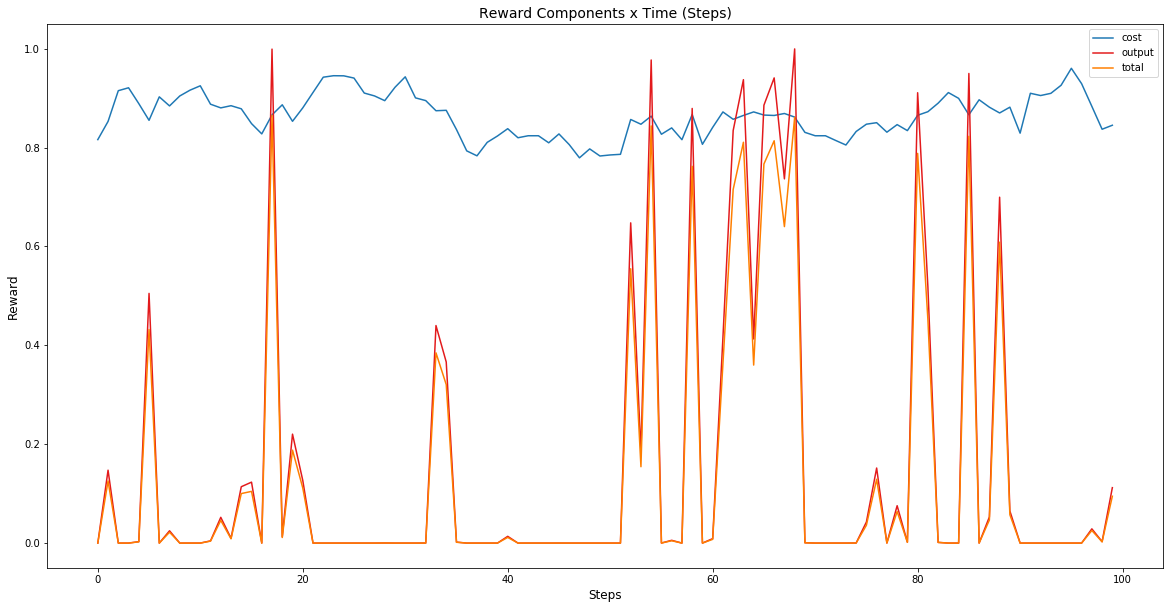

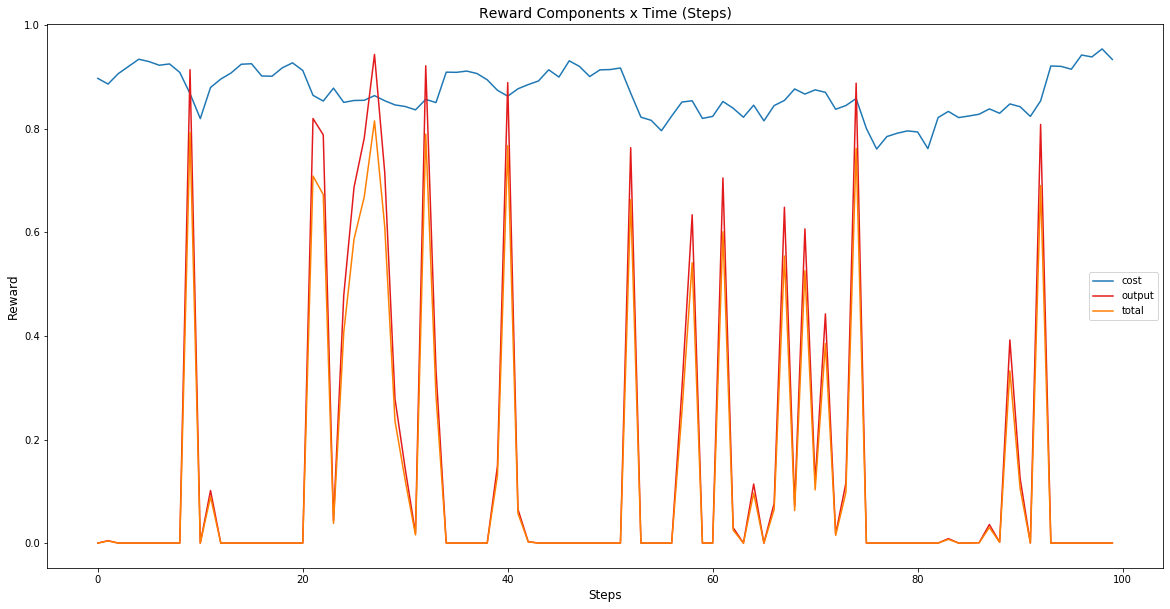

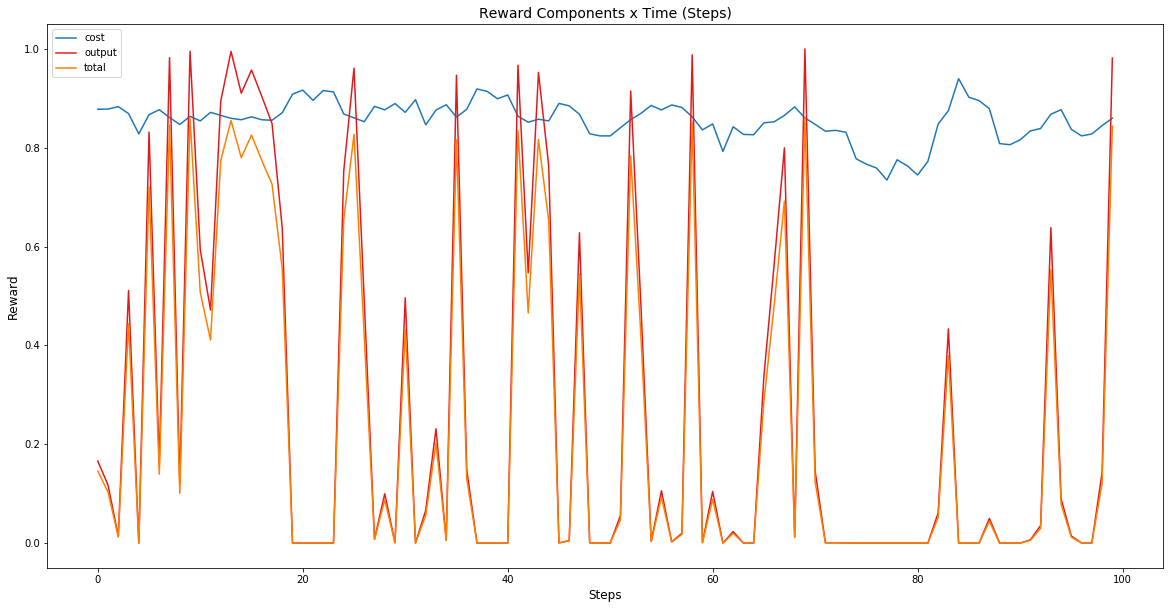

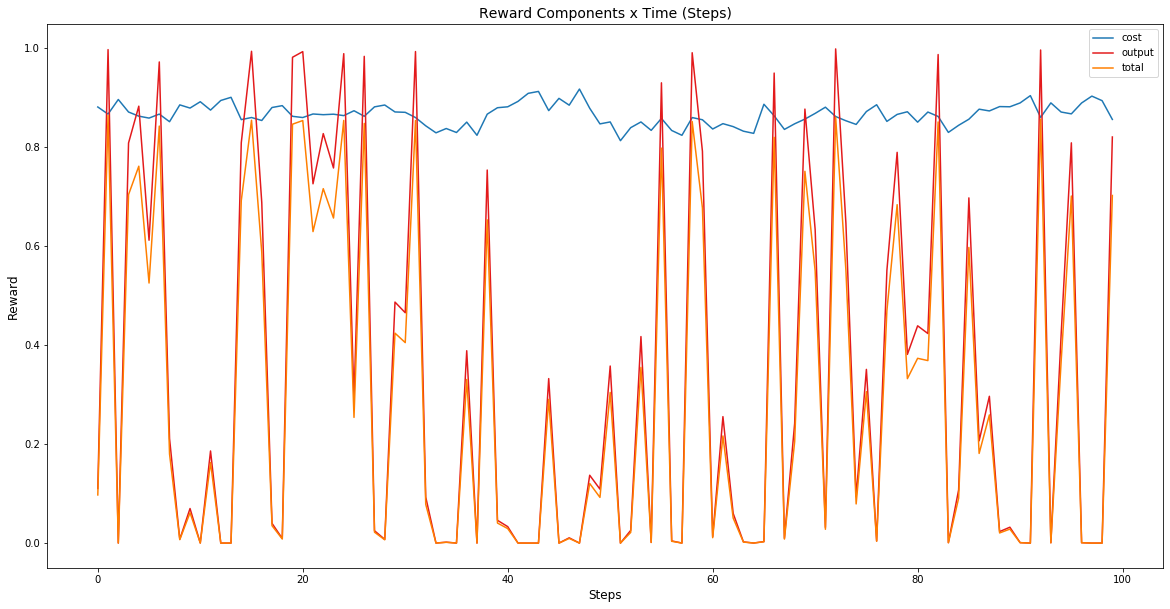

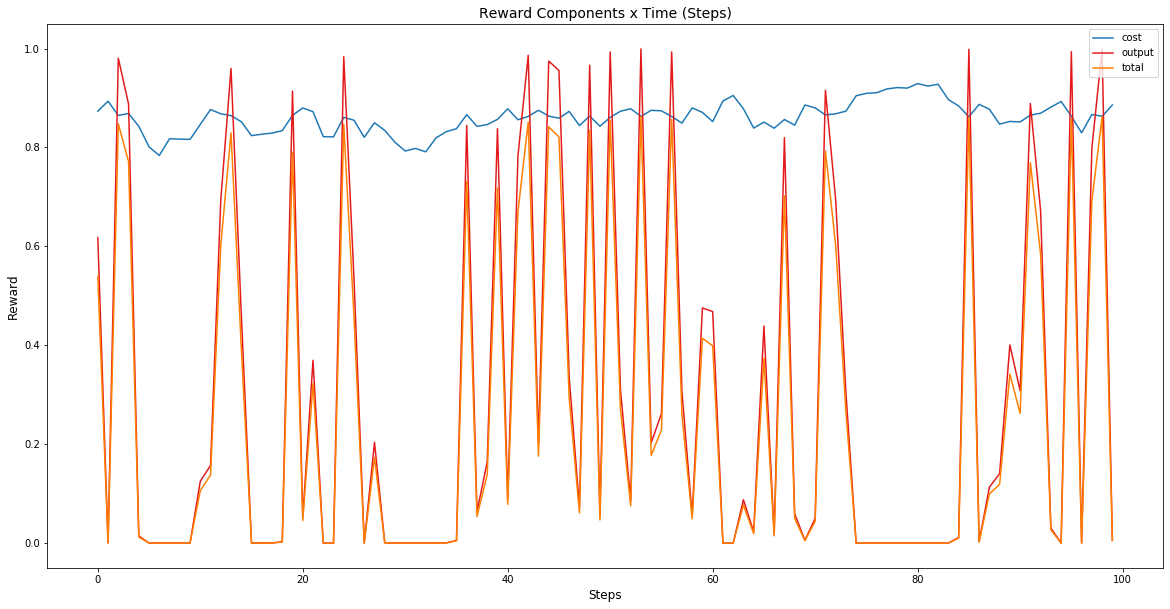

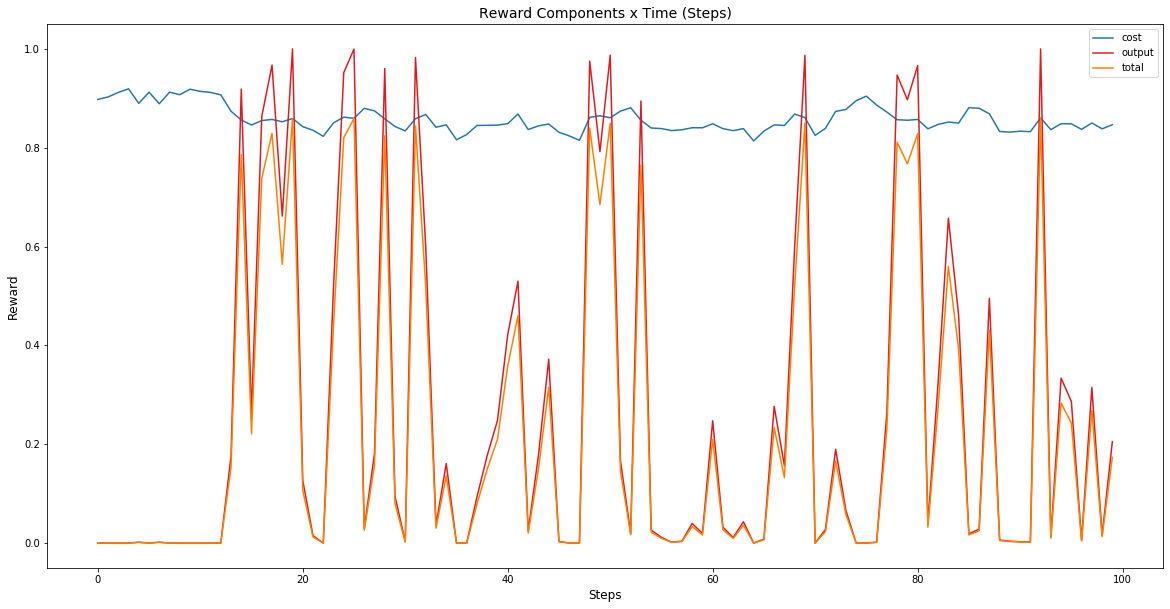

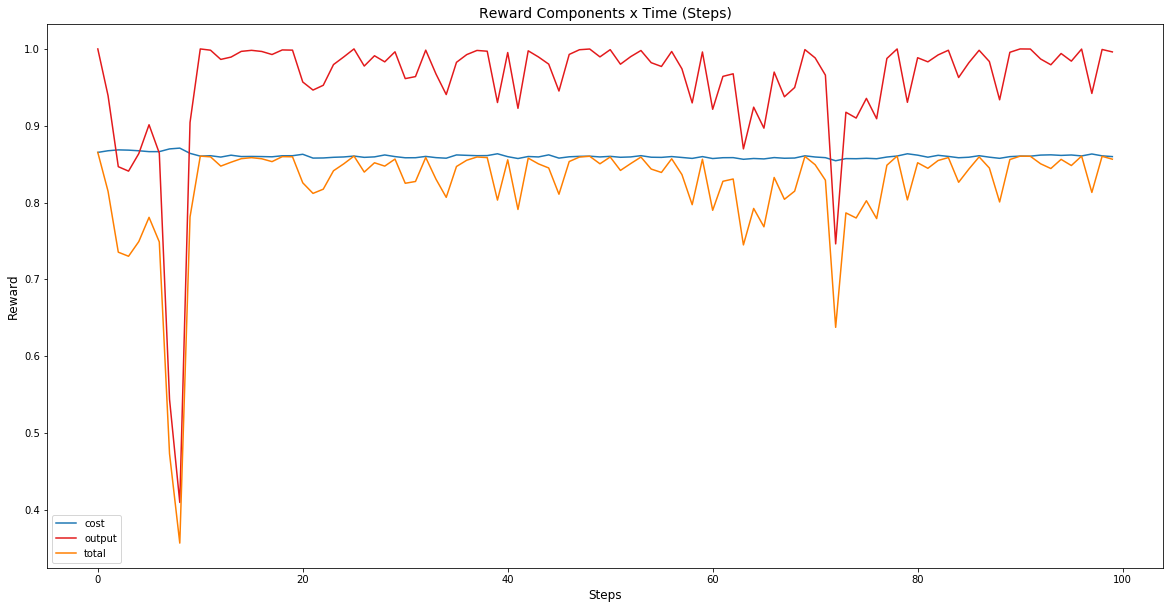

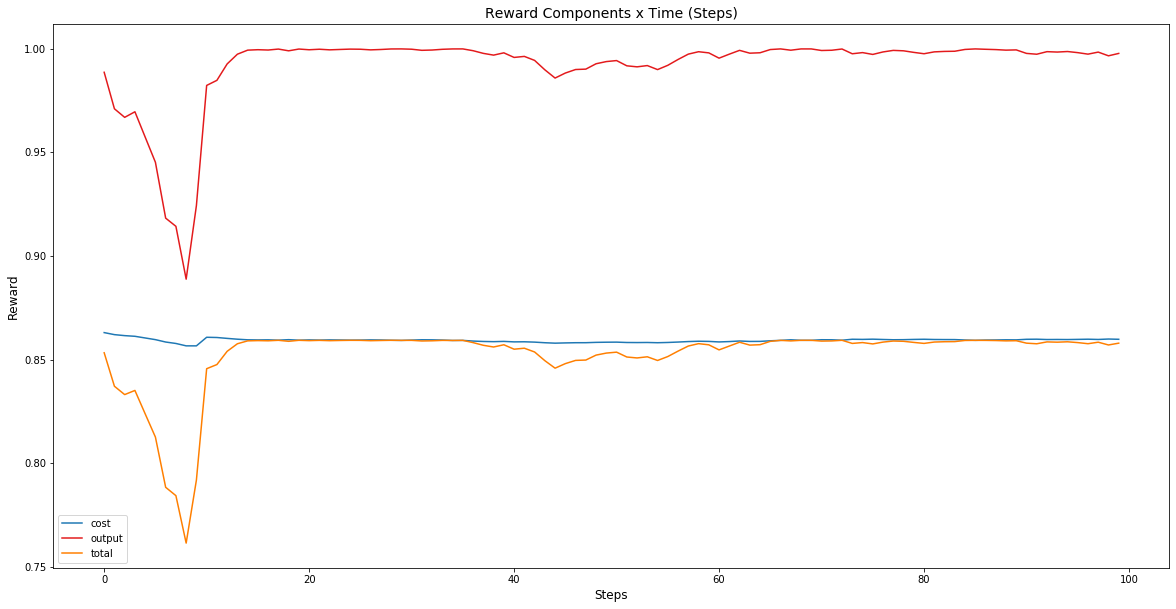

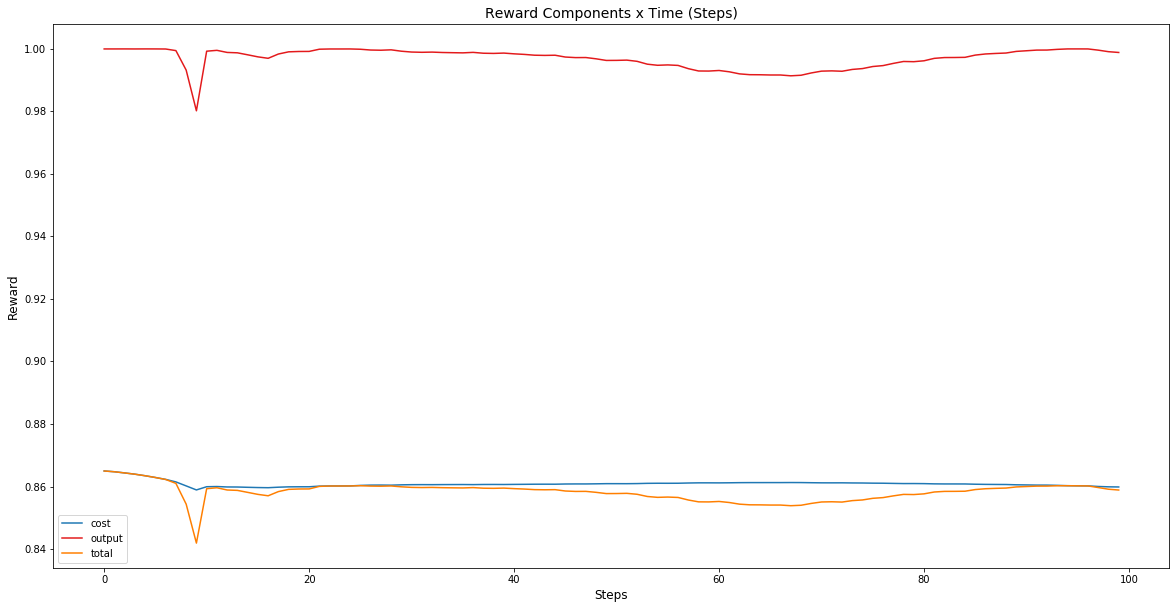

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

257.2626750811697

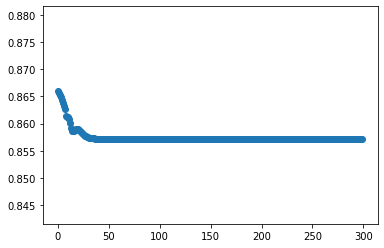

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

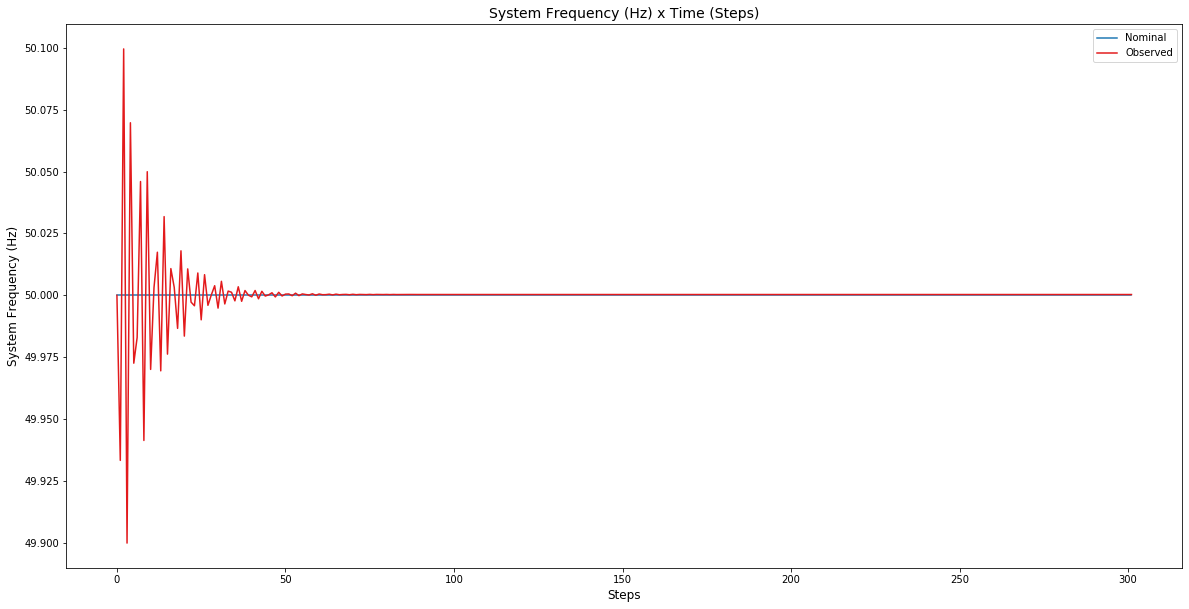

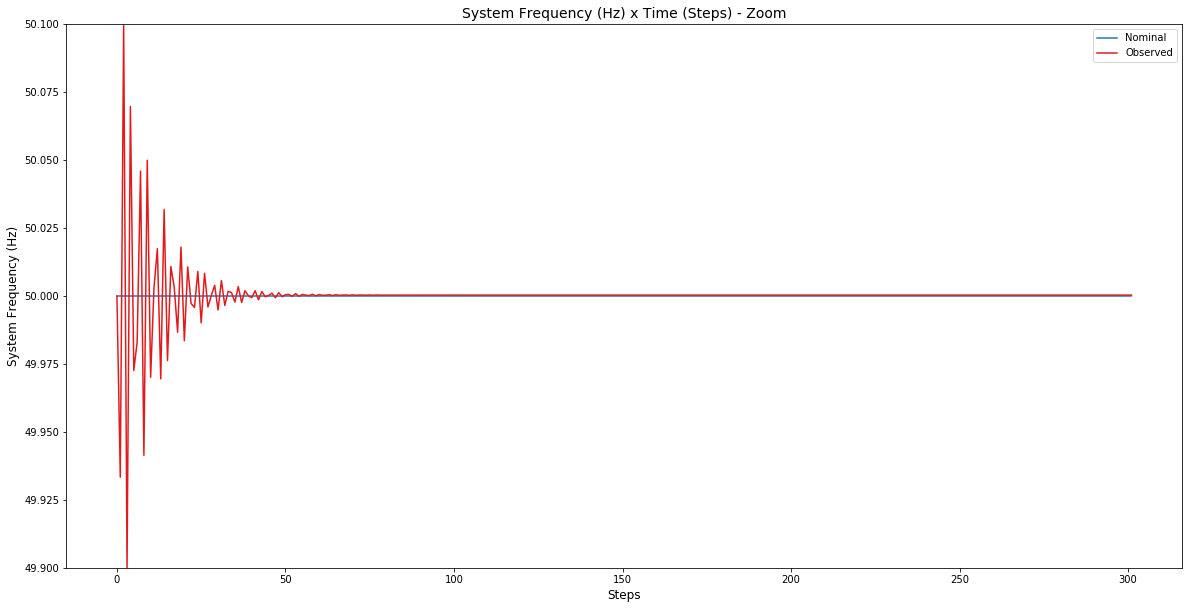

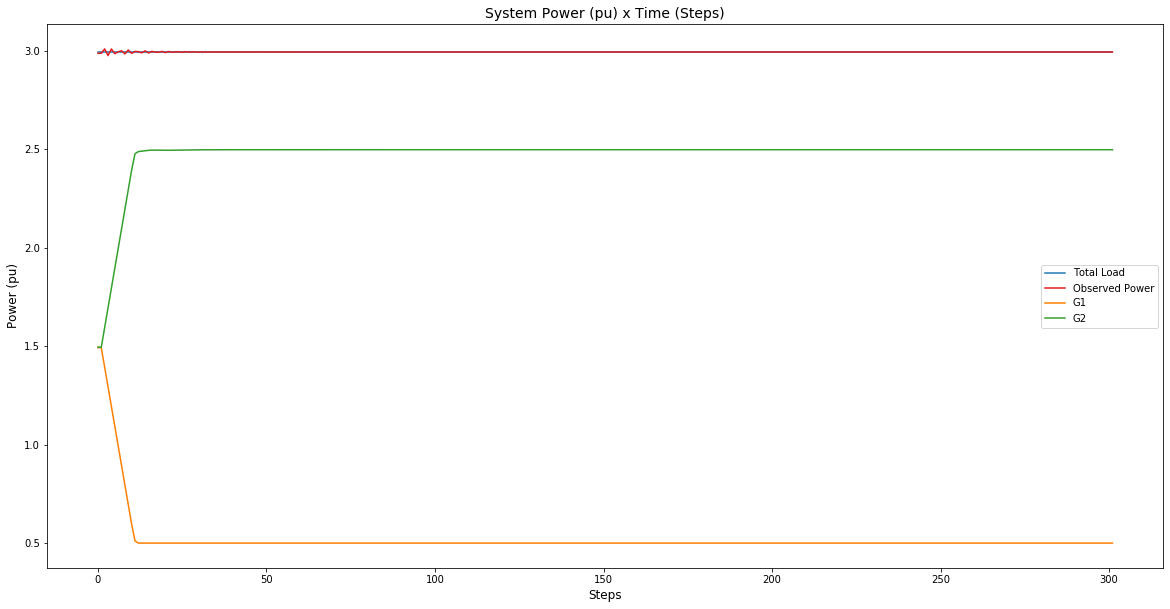

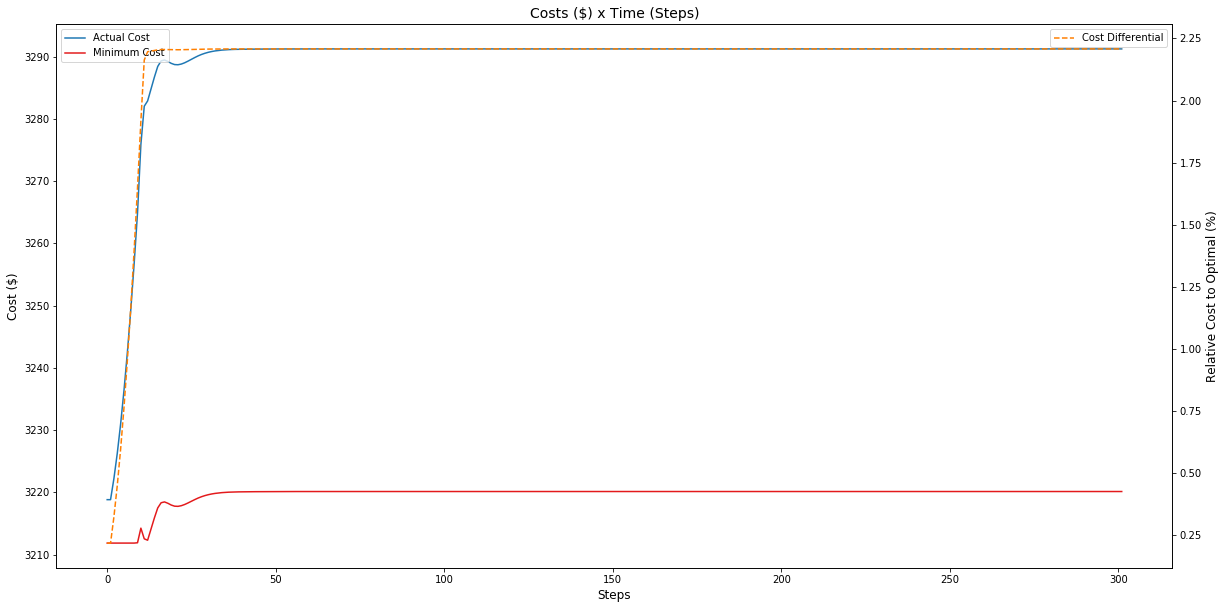

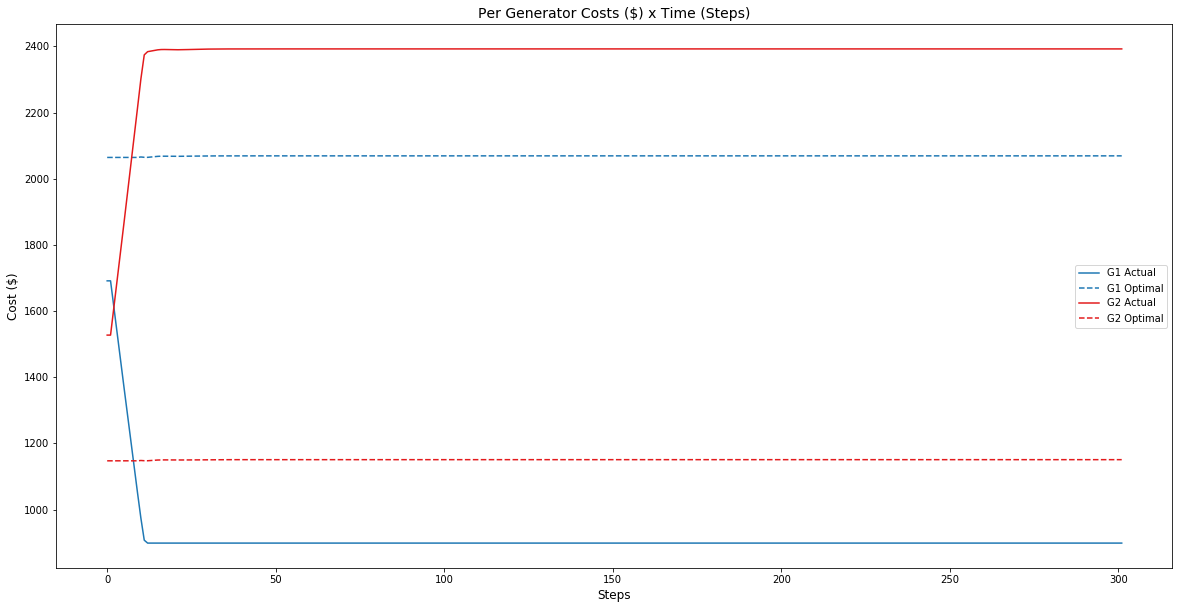

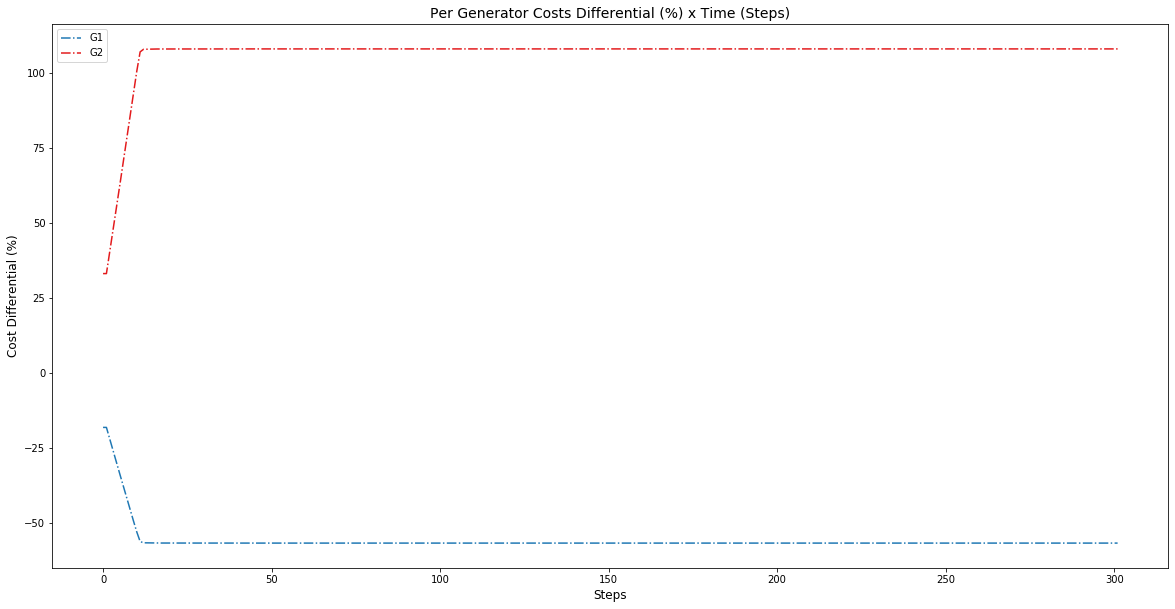

In [13]:
plotAll(electricalSystem.systemHistory)

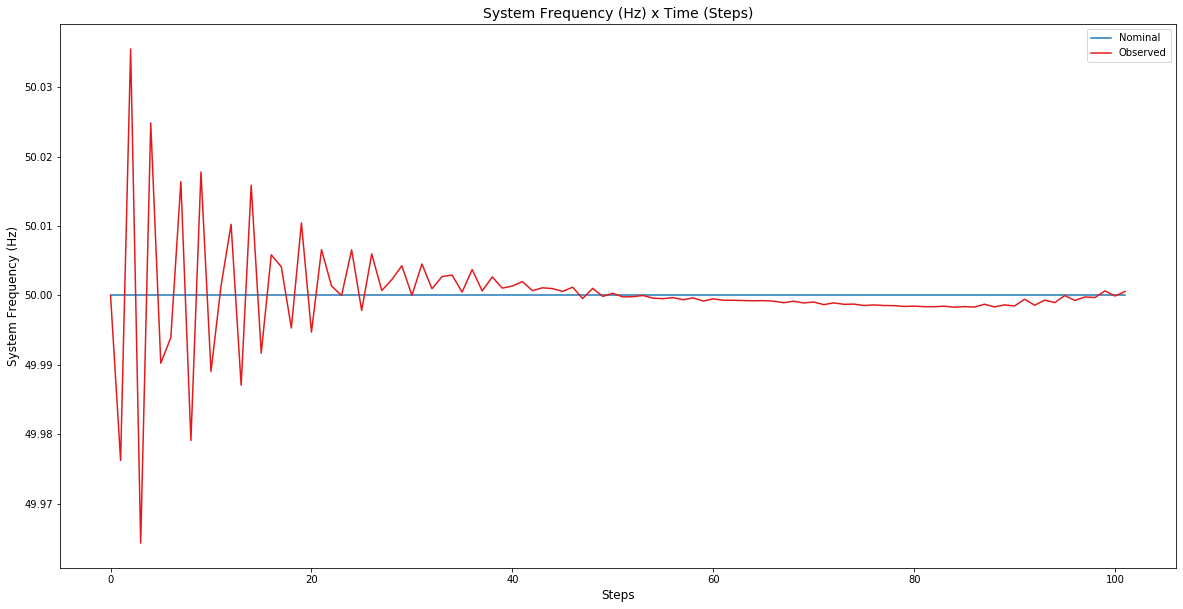

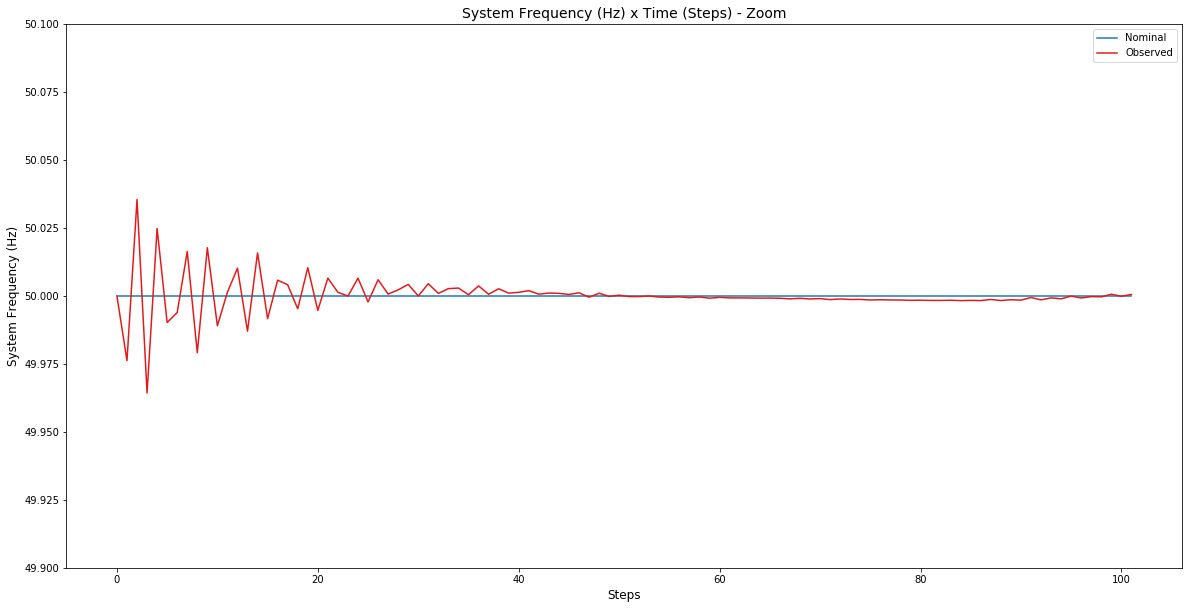

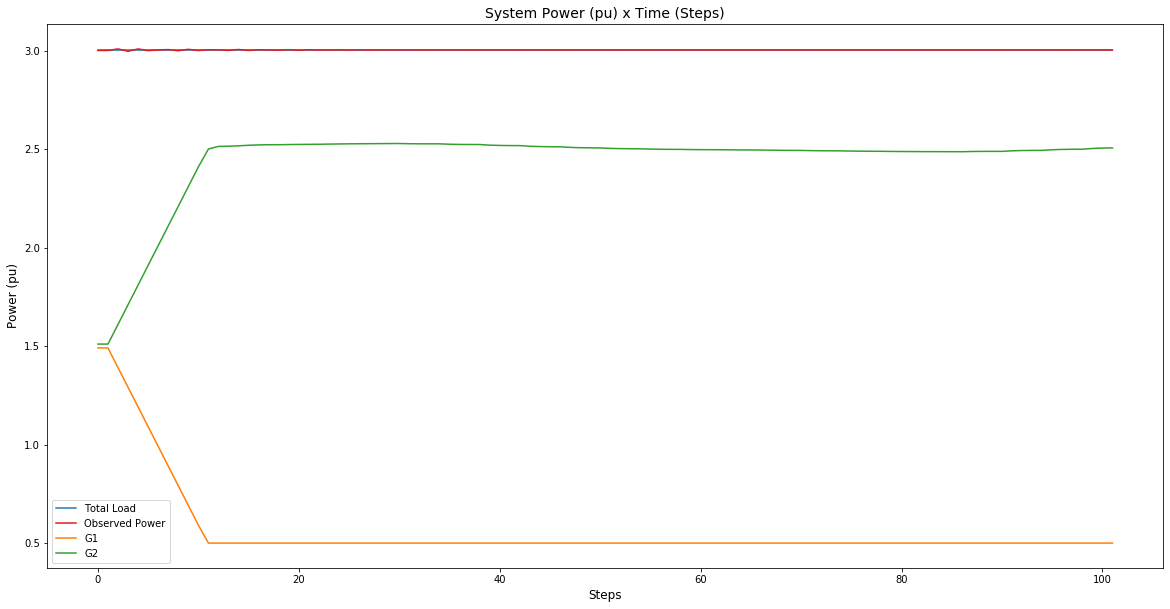

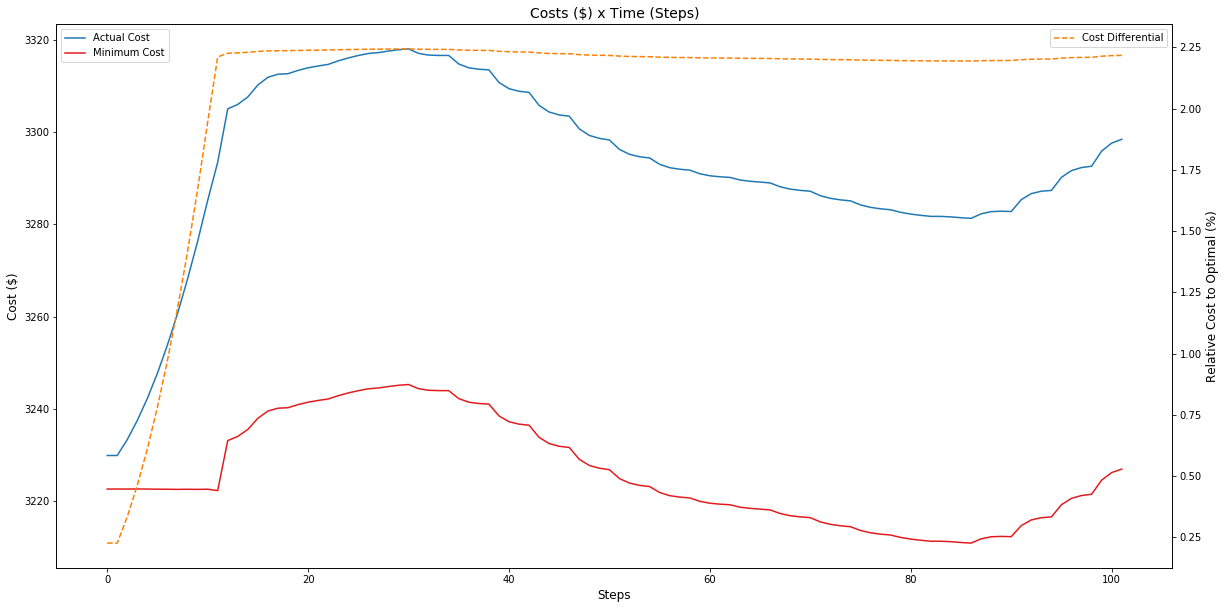

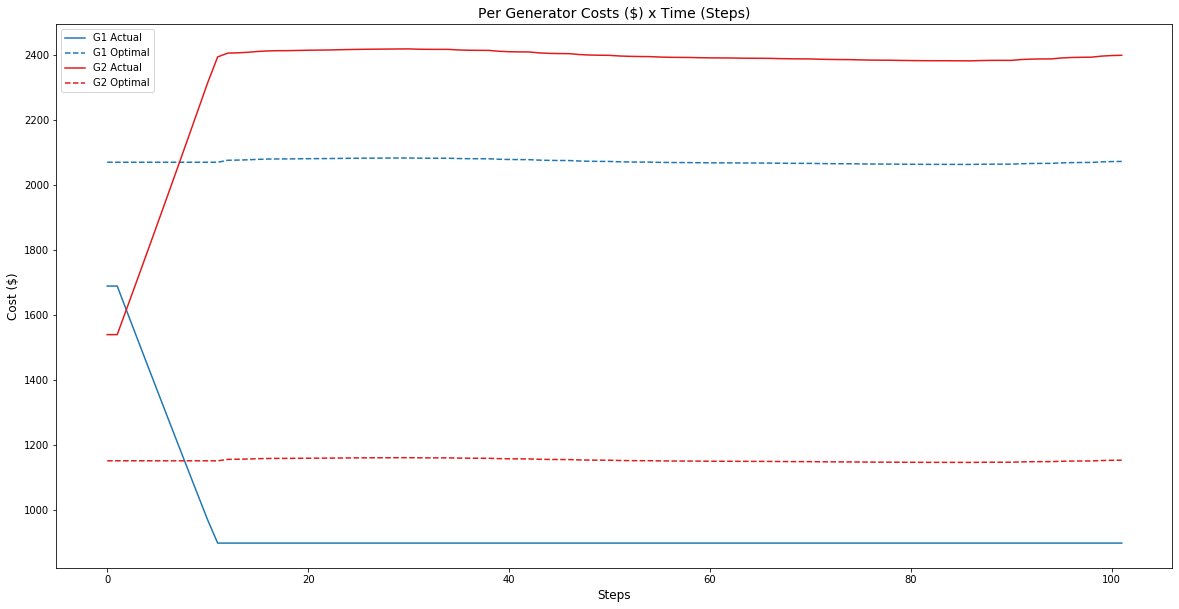

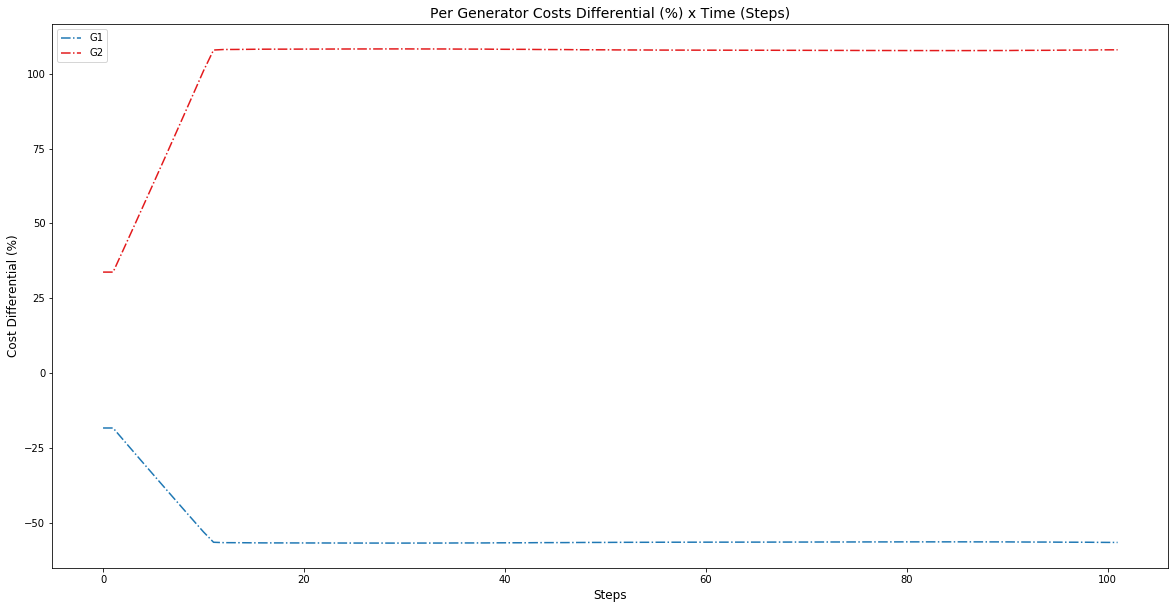

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.8160616741200436,
   'output': 6.852243758377714e-10,
   'total': 5.591853512940337e-10},
  {'cost': 0.8528124637797726,
   'output': 0.14743453096020134,
   'total': 0.12573400559438447},
  {'cost': 0.9150258068408474,
   'output': 3.32214082258144e-12,
   'total': 3.039844586621499e-12},
  {'cost': 0.9209189322524483,
   'output': 2.391804203326604e-16,
   'total': 2.202657773084454e-16},
  {'cost': 0.8888954543614224,
   'output': 0.00291223734238291,
   'total': 0.002588674535665758},
  {'cost': 0.8551093948314173,
   'output': 0.5050167223560629,
   'total': 0.43184454383363885},
  {'cost': 0.9025629214798265,
   'output': 2.55724037698716e-07,
   'total': 2.308070345579704e-07},
  {'cost': 0.8842155546403571,
   'output': 0.024839906795374858,
   'total': 0.021963831964287153},
  {'cost': 0.9043498612425428,
   'output': 2.5319460579267655e-08,
   'total': 2.2897650661596738e-08},
  {'cost': 0.9160861044021464,
   'output': 7.827656723807546e-14,
   'total': 7.170807

TypeError: float() argument must be a string or a number, not 'dict'

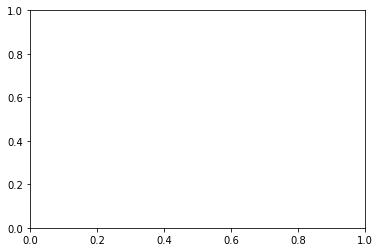

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()